# Error Analysis
* F1 score & Accuracy
* Classification report
* Confusion matrix
* Mean length of question, context, and concatenated input
* Proportion of tokens of the question in the concatenated input
* Mean of conjunction words in concatenated input
* Mean of negations in concatenated input
* Mean of numeric tokens in concatenated input
* (Mis-)Classification of questions based on the question word

In [ ]:
import spacy
import nltk
from bpemb import BPEmb
from transformers import AutoTokenizer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from dataclasses import dataclass
from datasets import load_dataset
import spacy
import pandas as pd
from sklearn import svm
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import fugashi
import matplotlib.pyplot as plt
import japanize_matplotlib
import time
from googletrans import Translator
from collections import defaultdict
from statistics import mean
import pickle
import gensim
from gensim.models import KeyedVectors
import random

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hannah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hannah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def loadDataset():
    """ Returns the raw TyDiQa dataset """
    dataset = load_dataset("copenlu/answerable_tydiqa")
    dataset = dataset.filter(lambda x: x["language"] == "english" or x["language"] == "finnish" or x["language"] == "japanese")
    train_set = dataset["train"]
    validation_set = dataset["validation"]
    training_data = answer_available(pd.DataFrame.from_dict(train_set))
    validation_data = answer_available(pd.DataFrame.from_dict(validation_set))
    training_data['question_context'] = training_data['question_text'] + ' ' + training_data['document_plaintext']
    validation_data['question_context'] = validation_data['question_text'] + ' ' + validation_data['document_plaintext']
    return training_data, validation_data

def answer_available(df):
    """Add a column indicating whether an answer is available in the context or not
    0: no answer available, 1: answer available"""
    df['answer_available'] = [0 if df['annotations'][i]['answer_text'] == [''] else 1 for i in range(len(df))]
    return df

def split_data(train_df, val_df, language):
    """Get training and validation data for one language"""
    train = train_df[train_df["language"] == language].reset_index(drop = True)
    val = val_df[val_df["language"] == language].reset_index(drop = True)
    return train, val

def preprocessing(text):
    """Prepare text: Convert everything to lowercase, remove punctuation, encoded and / or double+ whitespaces
    special quotationsmarks (found in japanese text), """
    # text = text.apply(lambda x: x.lower())
    text = re.sub('\[[0-9]+\]', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub('\s+', ' ', text)
    text = re.sub('”', '', text)
    return text

def do_nothing(tokens):
    return tokens

def tokenizeData(data, tokenizer, language, preprocessor = False):
    """Takes any iterable as input return lists of tokens in a list"""
    data = data['question_context']
    if preprocessor == True:
        data = data.apply(lambda x: preprocessing(x))
    # if tokenizer == 'bert':
    #     if language == 'english':
    #         tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    #     elif language == 'finnish':
    #         tokenizer = AutoTokenizer.from_pretrained("TurkuNLP/bert-base-finnish-uncased-v1")
    #     elif language == 'japanese':
    #         # Not recommended
    #         # https://github.com/polm/ipadic-py
    #         tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese")
    #     output_data = data.apply(lambda x: tokenizer.tokenize(x))
    if tokenizer == 'spacy':
        if language == 'english':
            tokenizer = spacy.load('en_core_web_sm')
        elif language == 'finnish':
            tokenizer = spacy.load("fi_core_news_sm")
        elif language == 'japanese':
            tokenizer = spacy.load('ja_core_news_sm')
        output_data = data.apply(lambda x: [token.text for token in tokenizer(x)])
    elif tokenizer == 'nltk':
        if language == 'english':
            output_data = data.apply(lambda x: word_tokenize(x, language = 'english'))
        elif language == 'finnish':
            output_data = data.apply(lambda x: word_tokenize(x, language = 'finnish'))
        elif language == 'japanese':
            print('NLTK does not support tokenization in japanese.')
            output_data = None
    elif tokenizer == 'fugashi':
        if language == 'japanese':
            tagger = fugashi.Tagger()
            output_data = data.apply(lambda x: [token.surface for token in tagger(x)])
        else:
            print('Fugashi only supports the language Japanese.')
            output_data = None
    return output_data

def most_common_tokens(data, language, save = False, plot = True):
    """any iterable as input, dictionary of first and last tokens, produces table or plot"""
    first_tokens = dict()
    last_tokens = dict()
    for tokens in data:
        try: 
            if tokens[0] in first_tokens.keys():
                first_tokens[tokens[0]] += 1
            else:
                first_tokens[tokens[0]] = 1
            if tokens[-1] in last_tokens.keys():
                last_tokens[tokens[-1]] += 1
            else:
                last_tokens[tokens[-1]] = 1
        except IndexError:
            pass
     # Sort dict
    first_tokens = dict(sorted(first_tokens.items(), key=lambda item: item[1], reverse = True))
    last_tokens = dict(sorted(last_tokens.items(), key=lambda item: item[1], reverse = True))

    if language == 'finnish' or language == 'japanese':
        first_translated = dict()
        last_translated = dict()
        translator = Translator()
        for key in first_tokens.keys():
            try: 
                first_translated[f'{key}_{translator.translate(key).text}'] = first_tokens[key]
            except:
                first_translated[f'{key}_[No translation available]'] = first_tokens[key]
        for key in last_tokens.keys():
            try:
                last_translated[f'{key}_{translator.translate(key).text}'] = last_tokens[key]
            except: 
                last_translated[f'{key}_[No translation available]'] = last_tokens[key]
        print(len(first_tokens.keys()), len(first_translated.keys()))
        print(len(last_tokens.keys()), len(last_tokens.keys()))
    
    if plot == False:
        if language == 'english':
            # Create dataframes
            df_first = pd.DataFrame({'token': first_tokens.keys(),
                      'count': first_tokens.values()})
            df_last = pd.DataFrame({'token': last_tokens.keys(),
                      'count': last_tokens.values()})
            return df_first, df_last
        else:
            # Create dataframes
            df_first = pd.DataFrame({'token': first_tokens.keys(), 
                                       'translated_token': first_translated.keys(),
                                       'count': first_tokens.values()})
            df_last = pd.DataFrame({'token': last_tokens.keys(),
                                      'translated_token': last_translated.keys(),
                                      'count': last_tokens.values()})
        return df_first, df_last
    
    else:
        if language == 'english':
            # Plot in barplot
            figure, axis = plt.subplots(1, 2, figsize=(12,5))

            axis[0].bar(list(first_tokens.keys())[:10], list(first_tokens.values())[:10])
            axis[0].set_title(f"Most common first tokens - {language}")
            axis[0].set_xticklabels(list(first_tokens.keys())[:10], rotation=45)
            # Last tokens
            axis[1].bar(list(last_tokens.keys())[:10], list(last_tokens.values())[:10])
            axis[1].set_title(f"Most common last tokens - {language}")
            axis[1].set_xticklabels(list(last_tokens.keys())[:10], rotation=45)
        else:
            figure, axis = plt.subplots(2, 2, figsize=(12,15))

            axis[0,0].bar(list(first_tokens.keys())[:10], list(first_tokens.values())[:10])
            axis[0,0].set_title(f"Most common first tokens - {language}")
            axis[0,0].set_xticklabels(list(first_tokens.keys())[:10], rotation=45)
                        # Last tokens
            axis[0,1].bar(list(last_tokens.keys())[:10], list(last_tokens.values())[:10])
            axis[0,1].set_title(f"Most common last tokens - {language}")
            axis[0,1].set_xticklabels(list(last_tokens.keys())[:10], rotation=45)

            axis[1,0].bar(list(first_translated.keys())[:10], list(first_translated.values())[:10])
            axis[1,0].set_title(f"Most common first tokens - translated")
            axis[1,0].set_xticklabels(list(first_translated.keys())[:10], rotation=45)
                        # Last tokens
            axis[1,1].bar(list(last_translated.keys())[:10], list(last_translated.values())[:10])
            axis[1,1].set_title(f"Most common last tokens - translated")
            axis[1,1].set_xticklabels(list(last_translated.keys())[:10], rotation=45)

        if save == False:
            plt.show()

        else:
            plt.savefig(f'token_overview_{"_".join(time.ctime().split())}.png')  


In [ ]:
def vectorize_tokens(training_tokens, validation_tokens, tfidf = False):
    """Vectorize tokens using either count values or tfidf weights if tfidf is set to True"""
    # Count vs. Tfidf vectorizer
    if tfidf == False:
        vectorizer = CountVectorizer(tokenizer = do_nothing, 
                                    preprocessor = do_nothing)
    else:
        vectorizer = TfidfVectorizer(tokenizer = do_nothing, 
                                    preprocessor = do_nothing)
    
    # Creating dfm
    vectorizer = vectorizer.fit(training_tokens)
    X_train = vectorizer.transform(training_tokens)
    X_val = vectorizer.transform(validation_tokens)
    return X_train, X_val

def embed_tokens(train_toks, val_toks, language, tfidf = True):
    """Vectorize tokens using FastText word embedding
    train_toks: training tokens
    val_toks: validation tokens
    language: english, finnish, japanese
    tfidf: When pooling the embedding matrix, compute the average using the tfidf scores as weights
          If tfidf is set to False all words in a document count equally when computing the mean
    Returns pooled mean vector per document"""

    # Loading the model
    if language == 'english':
        fasttext = KeyedVectors.load_word2vec_format('wiki.en.vec', binary=False)
    elif language == 'finnish':
        fasttext = KeyedVectors.load_word2vec_format('wiki.fi.vec', binary=False)
    elif language == 'japanese':
        fasttext = KeyedVectors.load_word2vec_format('wiki.ja.vec', binary=False)

    # Applying vectorizer
    if tfidf == True:
        vectorizer = TfidfVectorizer(tokenizer = do_nothing, 
                                preprocessor = do_nothing)
    else:
        vectorizer = CountVectorizer(tokenizer = do_nothing, 
                                     preprocessor = do_nothing)

    # Creating matrices with either count values or tfidf weights of features    
    vectorizer = vectorizer.fit(train_toks)
    X_train = vectorizer.transform(train_toks)
    X_val = vectorizer.transform(val_toks)
    
    # Create embedding matrix
    features = vectorizer.get_feature_names_out() # Get vocab
    unk = fasttext.vectors.mean(axis = 0) # Create vector for oov tokens: mean of all embedding vectors to account for distribution
    embedding_matrix=np.zeros((len(features), 300)) # create empty matrix
    
    # Fill the matrix with respective embedding of token
    for i in range(len(features)):
        try:
            embedding_matrix[i]=fasttext.get_vector(features[i])
        # If token not known by embedding, fill with OOV vector
        except KeyError:
            embedding_matrix[i] = unk

    # Create matrix of pooled doc embedding of size len of docs x dim of embedding
    doc_train = np.zeros((len(train_toks), 300))

    for i in range(len(train_toks)):
        # Fill every row with averaged embedding
        doc_train[i]= np.average(embedding_matrix, axis = 0, weights = X_train[i].toarray()[0])

    doc_val = np.zeros((len(val_toks), 300))

    for i in range(len(val_toks)):
        doc_val[i] = np.average(embedding_matrix, axis = 0, weights = X_val[i].toarray()[0])

    return doc_train, doc_val 


def lr_classifier(X_train, X_val, y_train, y_val):
    
    # Training LogisticRegression, random_state set to 42 
    log_mod = LogisticRegression(random_state = 42, max_iter = 1000).fit(X_train, y_train)
    
    # Evaluating model
    preds = log_mod.predict(X_val)
    probs = log_mod.predict_proba(X_val)
    
    f1 = f1_score(y_val, preds)
    acc = accuracy_score(y_val, preds)
    print(f'F1 = {f1}')
    print(f'Accuracy = {acc}')
    print(classification_report(y_val, preds))
    return preds, probs, log_mod   

def model_output(train_data, val_data, language, sparse = True, continuous = True):
    """Putting it all together
    sparse and continuous both set to True will combine the linguistic assumptions by tfidf weighting
        with continuous representations of words by word embeddings
    Only continuous set to True will use only continuous word representations using word embeddings
    Only sparse set to True will use only sparse word vectors using tfidf weighting"""

    y_train = np.array(train_data['answer_available'])
    y_val = np.array(val_data['answer_available'])
    
    if language == 'english':
                train_tok = tokenizeData(train_data, tokenizer = 'nltk', language = language, preprocessor = False)
                val_tok = tokenizeData(val_data, tokenizer = 'nltk', language = language, preprocessor = False)
                
    elif language == 'finnish':
            train_tok = tokenizeData(train_data, tokenizer = 'nltk', language = language, preprocessor = False) 
            val_tok = tokenizeData(val_data, tokenizer = 'nltk', language = language, preprocessor = False)

    elif language == 'japanese':
            train_tok = tokenizeData(train_data, tokenizer = 'fugashi', language = language, preprocessor = True)
            val_tok = tokenizeData(val_data, tokenizer = 'fugashi', language = language, preprocessor = True)

    if continuous == True:

        if sparse == True:
            print('Binary classifier combining linguistical features and continuous word representations')
            X_train, X_val = embed_tokens(train_tok, val_tok, language, tfidf = True)
            preds, probs, log_mod = lr_classifier(X_train, X_val, y_train, y_val) 
 
        else:
            print('Binary classifier using continuous word representations')
            X_train, X_val = embed_tokens(train_tok, val_tok, language, tfidf = False)
            preds, probs, log_mod = lr_classifier(X_train, X_val, y_train, y_val)
    
    elif sparse == True:
        print('Binary classifier using only linguistical features')
        if language == 'english':
            print(f"Tokenizer: Nltk, no preprocessing, tfidf weighting")
            X_train, X_val = vectorize_tokens(train_tok, val_tok, tfidf = True)
            preds, probs, log_mod = lr_classifier(X_train, X_val, y_train, y_val)
        elif language == 'finnish':
            print(f"Tokenizer: Nltk, no preprocessing, tfidf weighting")
            X_train, X_val = vectorize_tokens(train_tok, val_tok, tfidf = True)
            preds, probs, log_mod = lr_classifier(X_train, X_val, y_train, y_val)
        elif language == 'japanese':
            print(f"Tokenizer: Fugashi, preprocessing, tfidf weighting")
            X_train, X_val = vectorize_tokens(train_tok, val_tok, tfidf = True)
            preds, probs, log_mod = lr_classifier(X_train, X_val, y_train, y_val)
    
    return preds, probs, log_mod 
    

In [ ]:
def classification_overview(model, X_validation, y_validation):
    # Create predictions and prediction scores
    preds = model.predict(X_validation)
    probs = model.predict_proba(X_validation)
    
    # Print out f1, acc, classification report and confusion matrix
    print(f'F1 score: {f1_score(y_validation, preds)}')
    print(f'Accuracy score: {accuracy_score(y_validation, preds)}')
    print(f'Classification Report: \n{classification_report(y_validation, preds)}')
    print(f'Confusion Matrix: \n{confusion_matrix(y_validation, preds)}')
    return preds, probs

def prediction_overview(val_data, model, preds, probs):
    errors = defaultdict(lambda: [])
    correct = defaultdict(lambda: [])

    for (i, entry), prediction, probability in zip(val_data.iterrows(), preds, probs):

        idx_class = np.where(model.classes_ == entry[6])
        idx_predclass = np.where(model.classes_ == prediction)

        if prediction != entry[6]:
            # input, probability of actual class, probability of predicted class, prediction [0,1]
            errors[entry[6]].append([entry[0], entry[4], entry[7], probability[idx_class], probability[idx_predclass], prediction])
        else:
            correct[entry[6]].append([entry[0], entry[4], entry[7], probability[idx_class], probability[idx_predclass], prediction])
    return errors, correct

def class_ov_transformer(y_validation, preds):
    
    # Print out f1, acc, classification report and confusion matrix
    print(f'F1 score: {f1_score(y_validation, preds)}')
    print(f'Accuracy score: {accuracy_score(y_validation, preds)}')
    print(f'Classification Report: \n{classification_report(y_validation, preds)}')
    print(f'Confusion Matrix: \n{confusion_matrix(y_validation, preds)}')
    
def create_arrays(errors, correct):
    true = np.repeat(0, len(correct[0]) + len(errors[0]))
    true = np.append(true, np.repeat(1, len(correct[1]) + len(errors[1])))
    
    prediction = np.repeat(0, len(correct[0]))
    prediction = np.append(prediction, np.repeat(1, len(errors[0])))
    prediction = np.append(prediction, np.repeat(1, len(correct[1])))
    prediction = np.append(prediction, np.repeat(0, len(errors[1])))
    
    return true, prediction

def input_length(errors, correct, language):
    if language == 'english' or language == 'finnish':
        for entry in correct[0]:
            tokens_qst = word_tokenize(entry[0], language = language)
            tokens_ctxt = word_tokenize(entry[1], language = language)
            entry.extend([tokens_qst, len(tokens_qst), tokens_ctxt, len(tokens_ctxt), len(tokens_qst + tokens_ctxt),
                         len(tokens_qst)/len(tokens_qst + tokens_ctxt)])
            
        for entry in correct[1]:
            tokens_qst = word_tokenize(entry[0], language = language)
            tokens_ctxt = word_tokenize(entry[1], language = language)
            entry.extend([tokens_qst, len(tokens_qst), tokens_ctxt, len(tokens_ctxt), len(tokens_qst + tokens_ctxt),
                         len(tokens_qst)/len(tokens_qst + tokens_ctxt)])
            
        for entry in errors[0]:
            tokens_qst = word_tokenize(entry[0], language = language)
            tokens_ctxt = word_tokenize(entry[1], language = language)
            entry.extend([tokens_qst, len(tokens_qst), tokens_ctxt, len(tokens_ctxt), len(tokens_qst + tokens_ctxt),
                         len(tokens_qst)/len(tokens_qst + tokens_ctxt)])
            
        for entry in errors[1]:
            tokens_qst = word_tokenize(entry[0], language = language)
            tokens_ctxt = word_tokenize(entry[1], language = language)
            entry.extend([tokens_qst, len(tokens_qst), tokens_ctxt, len(tokens_ctxt), len(tokens_qst + tokens_ctxt),
                         len(tokens_qst)/len(tokens_qst + tokens_ctxt)])
        
    elif language == 'japanese':
        tagger = fugashi.Tagger()
        for entry in correct[0]:
            tokens_qst = [token.surface for token in tagger(entry[0])]
            tokens_ctxt = [token.surface for token in tagger(entry[1])]
            entry.extend([tokens_qst, len(tokens_qst), tokens_ctxt, len(tokens_ctxt), len(tokens_qst + tokens_ctxt),
                         len(tokens_qst)/len(tokens_qst + tokens_ctxt)])
            
        for entry in correct[1]:
            tokens_qst = [token.surface for token in tagger(entry[0])]
            tokens_ctxt = [token.surface for token in tagger(entry[1])]
            entry.extend([tokens_qst, len(tokens_qst), tokens_ctxt, len(tokens_ctxt), len(tokens_qst + tokens_ctxt),
                         len(tokens_qst)/len(tokens_qst + tokens_ctxt)])
            
        for entry in errors[0]:
            tokens_qst = [token.surface for token in tagger(entry[0])]
            tokens_ctxt = [token.surface for token in tagger(entry[1])]
            entry.extend([tokens_qst, len(tokens_qst), tokens_ctxt, len(tokens_ctxt), len(tokens_qst + tokens_ctxt),
                         len(tokens_qst)/len(tokens_qst + tokens_ctxt)])
            
        for entry in errors[1]:
            tokens_qst = [token.surface for token in tagger(entry[0])]
            tokens_ctxt = [token.surface for token in tagger(entry[1])]
            entry.extend([tokens_qst, len(tokens_qst), tokens_ctxt, len(tokens_ctxt), len(tokens_qst + tokens_ctxt),
                         len(tokens_qst)/len(tokens_qst + tokens_ctxt)])
            
    # length_actuallabel_predlabel - Question
    length_10 = [x[7] for x in errors[1]]
    length_01 = [x[7] for x in errors[0]]

    length_11 = [x[7] for x in correct[1]]
    length_00 = [x[7] for x in correct[0]]
    
    print(f'Mean of incorrectly classified answerable questions as unanswerable - Qst = {mean(length_10)}')
    print(f'Mean of incorrectly classified unanswerable questions as answerable - Qst = {mean(length_01)}')

    print(f'Mean of correctly classified answerable questions - Qst = {mean(length_11)}')
    print(f'Mean of correctly classified unanswerable questions - Qst = {mean(length_00)}')
    
    # length_actuallabel_predlabel - Context
    length_10 = [x[9] for x in errors[1]]
    length_01 = [x[9] for x in errors[0]]

    length_11 = [x[9] for x in correct[1]]
    length_00 = [x[9] for x in correct[0]]
    
    print(f'Mean of incorrectly classified answerable questions as unanswerable - Ctxt = {mean(length_10)}')
    print(f'Mean of incorrectly classified unanswerable questions as answerable - Ctxt = {mean(length_01)}')

    print(f'Mean of correctly classified answerable questions - Ctxt = {mean(length_11)}')
    print(f'Mean of correctly classified unanswerable questions - Ctxt = {mean(length_00)}')
    
    # length_actuallabel_predlabel - Question + Context
    length_10 = [x[10] for x in errors[1]]
    length_01 = [x[10] for x in errors[0]]

    length_11 = [x[10] for x in correct[1]]
    length_00 = [x[10] for x in correct[0]]
    
    print(f'Mean of incorrectly classified answerable questions as unanswerable - QstCtxt = {mean(length_10)}')
    print(f'Mean of incorrectly classified unanswerable questions as answerable - QstCtxt = {mean(length_01)}')

    print(f'Mean of correctly classified answerable questions - QstCtxt = {mean(length_11)}')
    print(f'Mean of correctly classified unanswerable questions - QstCtxt = {mean(length_00)}')
    
    # length_actuallabel_predlabel - Proportion of qst
    length_10 = [x[11] for x in errors[1]]
    length_01 = [x[11] for x in errors[0]]

    length_11 = [x[11] for x in correct[1]]
    length_00 = [x[11] for x in correct[0]]
    
    print(f'Mean_length of incorrectly classified answerable questions as unanswerable - PropQst = {mean(length_10)}')
    print(f'Mean_length of incorrectly classified unanswerable questions as answerable - PropQst = {mean(length_01)}')

    print(f'Mean_length of correctly classified answerable questions - PropQst = {mean(length_11)}')
    print(f'Mean_length of correctly classified unanswerable questions - PropQst = {mean(length_00)}')
            
    return errors, correct

def overlap(errors, correct):
    for entry in errors[1]:
        entry.append(len([word for word in entry[6] if word in entry[8]]))

    for entry in errors[0]:
        entry.append(len([word for word in entry[6] if word in entry[8]]))

    for entry in correct[1]:
        entry.append(len([word for word in entry[6] if word in entry[8]]))

    for entry in correct[0]:
        entry.append(len([word for word in entry[6] if word in entry[8]]))
     
    # overlap_actuallabel_predlabel - QstCtxt
    overlap_10 = [x[12] for x in errors[1]]
    overlap_01 = [x[12] for x in errors[0]]

    overlap_11 = [x[12] for x in correct[1]]
    overlap_00 = [x[12] for x in correct[0]]
    
    print(f'Mean_overlap of incorrectly classified answerable questions as unanswerable - QstCtxt = {mean(overlap_10)}')
    print(f'Mean_overlap of incorrectly classified unanswerable questions as answerable - QstCtxt = {mean(overlap_01)}')

    print(f'Mean_overlap of correctly classified answerable questions - QstCtxt = {mean(overlap_11)}')
    print(f'Mean_overlap of correctly classified unanswerable questions - QstCtxt = {mean(overlap_00)}')
    
    return errors, correct

def semantic_features(errors, correct):
    conjunction = ['for', 'or', 'and', 'nor', 'but', 'yet', 'so'] # FANBOYS coordinate conjuctions
    negation = ['not', 'no']
    
    for entry in errors[1]:
        entry.append(len([word for word in entry[6] if word in conjunction]) + len([word for word in entry[8] if word in conjunction]))
        entry.append(len([word for word in entry[6] if word in negation]) + len([word for word in entry[8] if word in negation]))

    for entry in errors[0]:
        entry.append(len([word for word in entry[6] if word in conjunction]) + len([word for word in entry[8] if word in conjunction]))
        entry.append(len([word for word in entry[6] if word in negation]) + len([word for word in entry[8] if word in negation]))

    for entry in correct[1]:
        entry.append(len([word for word in entry[6] if word in conjunction]) + len([word for word in entry[8] if word in conjunction]))
        entry.append(len([word for word in entry[6] if word in negation]) + len([word for word in entry[8] if word in negation]))

    for entry in correct[0]:
        entry.append(len([word for word in entry[6] if word in conjunction]) + len([word for word in entry[8] if word in conjunction]))
        entry.append(len([word for word in entry[6] if word in negation]) + len([word for word in entry[8] if word in negation]))

    # con_actuallabel_predlabel - QstCtxt
    con_10 = [x[13] for x in errors[1]]
    con_01 = [x[13] for x in errors[0]]
    
    con_11 = [x[13] for x in correct[1]]
    con_00 = [x[13] for x in correct[0]]
    
    print(f'Mean_conjunction of incorrectly classified answerable questions as unanswerable - QstCtxt = {mean(con_10)}')
    print(f'Mean_conjunction of incorrectly classified unanswerable questions as answerable - QstCtxt = {mean(con_01)}')

    print(f'Mean_conjunction of correctly classified answerable questions - QstCtxt = {mean(con_11)}')
    print(f'Mean_conjunction of correctly classified unanswerable questions - QstCtxt = {mean(con_00)}')
    
    # Negation_actuallabel_predlabel - QstCtxt
    neg_10 = [x[14] for x in errors[1]]
    neg_01 = [x[14] for x in errors[0]]
    
    neg_11 = [x[14] for x in correct[1]]
    neg_00 = [x[14] for x in correct[0]]
    
    print(f'Mean_negation of incorrectly classified answerable questions as unanswerable - QstCtxt = {mean(neg_10)}')
    print(f'Mean_negation of incorrectly classified unanswerable questions as answerable - QstCtxt = {mean(neg_01)}')

    print(f'Mean_negation of correctly classified answerable questions - QstCtxt = {mean(neg_11)}')
    print(f'Mean_negation of correctly classified unanswerable questions - QstCtxt = {mean(neg_00)}')
    
    return errors, correct

def numbers(errors, correct):
    for entry in errors[1]:
        entry.append(len([word for word in entry[6] if word.isnumeric()]) + len([word for word in entry[8] if word.isnumeric()]))

    for entry in errors[0]:
        entry.append(len([word for word in entry[6] if word.isnumeric()]) + len([word for word in entry[8] if word.isnumeric()]))
        
    for entry in correct[1]:
        entry.append(len([word for word in entry[6] if word.isnumeric()]) + len([word for word in entry[8] if word.isnumeric()]))

    for entry in correct[0]:
        entry.append(len([word for word in entry[6] if word.isnumeric()]) + len([word for word in entry[8] if word.isnumeric()]))

    # Num_actuallabel_predlabel - QstCtxt
    num_10 = [x[15] for x in errors[1]]
    num_01 = [x[15] for x in errors[0]]
    
    num_11 = [x[15] for x in correct[1]]
    num_00 = [x[15] for x in correct[0]]
    
    print(f'Mean_number of incorrectly classified answerable questions as unanswerable - QstCtxt = {mean(num_10)}')
    print(f'Mean_number of incorrectly classified unanswerable questions as answerable - QstCtxt = {mean(num_01)}')

    print(f'Mean_number of correctly classified answerable questions - QstCtxt = {mean(num_11)}')
    print(f'Mean_number of correctly classified unanswerable questions - QstCtxt = {mean(num_00)}')
    
    return errors, correct
    
   
        
def pred_qstword(errors, correct, language):
    unanswerable_true = dict()
    answerable_true = dict()
    unanswerable_false = dict()
    answerable_false = dict()
    
    if language == 'english' or language == 'finnish':
        for entry in correct[0]:
            tokens = word_tokenize(entry[0], language = language)
            if tokens[0] in unanswerable_true.keys():
                unanswerable_true[tokens[0]] += 1
            else:
                unanswerable_true[tokens[0]] = 1

        for entry in correct[1]:
            tokens = word_tokenize(entry[0], language = language)
            if tokens[0] in answerable_true.keys():
                answerable_true[tokens[0]] += 1
            else:
                answerable_true[tokens[0]] = 1

        for entry in errors[0]:
            tokens = word_tokenize(entry[0], language = language)
            if tokens[0] in unanswerable_false.keys():
                unanswerable_false[tokens[0]] += 1
            else:
                unanswerable_false[tokens[0]] = 1

        for entry in errors[1]:
            tokens = word_tokenize(entry[0], language = language)
            if tokens[0] in answerable_false.keys():
                answerable_false[tokens[0]] += 1
            else:
                answerable_false[tokens[0]] = 1
                
    elif language == 'japanese':
        tagger = fugashi.Tagger()
        for entry in correct[0]:
            tokens = [token.surface for token in tagger(entry[0])]
            if tokens[-1] in unanswerable_true.keys():
                unanswerable_true[tokens[-1]] += 1
            else:
                unanswerable_true[tokens[-1]] = 1

        for entry in correct[1]:
            tokens = [token.surface for token in tagger(entry[0])]
            if tokens[-1] in answerable_true.keys():
                answerable_true[tokens[-1]] += 1
            else:
                answerable_true[tokens[-1]] = 1

        for entry in errors[0]:
            tokens = [token.surface for token in tagger(entry[0])]
            if tokens[-1] in unanswerable_false.keys():
                unanswerable_false[tokens[-1]] += 1
            else:
                unanswerable_false[tokens[-1]] = 1

        for entry in errors[1]:
            tokens = [token.surface for token in tagger(entry[0])]
            if tokens[-1] in answerable_false.keys():
                answerable_false[tokens[-1]] += 1
            else:
                answerable_false[tokens[-1]] = 1
    
    # Unanswerable questions
    df_true = pd.DataFrame({'qst_word': list(unanswerable_true.keys()),
                       'count_true': list(unanswerable_true.values())})
    df_false = pd.DataFrame({'qst_word': list(unanswerable_false.keys()),
                       'count_false': list(unanswerable_false.values())})
    unanswerable = pd.merge(df_true, df_false, on = 'qst_word', how = 'outer').fillna(0)
    unanswerable['rel_true'] = unanswerable['count_true'].apply(lambda x: x/unanswerable['count_true'].sum())
    unanswerable['rel_false'] = unanswerable['count_false'].apply(lambda x: x/unanswerable['count_false'].sum())
    unanswerable['language'] = language
    
    # Answerable questions
    df_true = pd.DataFrame({'qst_word': list(answerable_true.keys()),
                       'count_true': list(answerable_true.values())})
    df_false = pd.DataFrame({'qst_word': list(answerable_false.keys()),
                       'count_false': list(answerable_false.values())})
    answerable = pd.merge(df_true, df_false, on = 'qst_word', how = 'outer').fillna(0)
    answerable['rel_true'] = answerable['count_true'].apply(lambda x: x/answerable['count_true'].sum())
    answerable['rel_false'] = answerable['count_false'].apply(lambda x: x/answerable['count_false'].sum())
    answerable['language'] = language
    if language == 'finnish' or language == 'japanese':
        translator = Translator()
        for idx in range(len(unanswerable['qst_word'])):
            try: 
                unanswerable['qst_word'][idx] = f'{unanswerable["qst_word"][idx]}_{translator.translate(unanswerable["qst_word"][idx]).text}'
            except:
                unanswerable['qst_word'][idx] = f'{unanswerable["qst_word"][idx]}_[TransFailed]'
        for idx in range(len(answerable['qst_word'])):
            try: 
                answerable['qst_word'][idx] = f'{answerable["qst_word"][idx]}_{translator.translate(answerable["qst_word"][idx]).text}'
            except:
                answerable['qst_word'][idx] = f'{answerable["qst_word"][idx]}_[TransFailed]'
    return unanswerable, answerable

def plot_qstwords(unanswerable, answerable, save = False, model_type = None):
    words_unan = unanswerable['qst_word']
    x_unan = np.arange(len(words_unan))
    words_an = answerable['qst_word']
    x_an = np.arange(len(words_an))
    
    # Create plot
    figure, axis = plt.subplots(1, 2, figsize=(12,5))

    # Plotting unanswerable questions, correctly classified + incorrectly classified (i.e. as answerable)
    axis[0].bar(x_unan - 0.2, unanswerable['rel_true'], width = 0.4, label = 'Correctly classified', 
           edgecolor = 'black')
    axis[0].bar(x_unan + 0.2, unanswerable['rel_false'], width = 0.4, label = 'Incorrectly classified',
           edgecolor = 'black')
    axis[0].set_xlabel('Starting token of questions')
    axis[0].set_xticks(x_unan, words_unan, rotation = 90)
    axis[0].set_ylabel('Relative frequency')
    axis[0].set_title('Distribution of Question Words - Unanswerable Questions')
    axis[0].legend()
 
    # Plotting answerable questions, correctly classified + incorrectly classified (i.e. as unanswerable)
    axis[1].bar(x_an - 0.2, answerable['rel_true'], width = 0.4, label = 'Correctly classified', 
           edgecolor = 'black')
    axis[1].bar(x_an + 0.2, answerable['rel_false'], width = 0.4, label = 'Incorrectly classified',
           edgecolor = 'black')
    axis[1].set_xlabel('Starting token of questions')
    axis[1].set_xticks(x_an, words_an, rotation = 90)
    axis[1].set_ylabel('Relative frequency')
    axis[1].set_title('Distribution of Question Words - Answerable Questions')
    axis[1].legend()
    
    if save == True:
        plt.savefig(f'PredictionStartingToken_{model_type}_{unanswerable["language"][0]}.png')
    else:
        plt.show()

In [ ]:
training_data, validation_data = loadDataset()
# Split by language
train_en, val_en = split_data(training_data, validation_data, 'english')
train_fi, val_fi = split_data(training_data, validation_data, 'finnish')
train_ja, val_ja = split_data(training_data, validation_data, 'japanese')

Using custom data configuration copenlu--nlp_course_tydiqa-cceecfb5416d988a
Reusing dataset parquet (C:\Users\Hannah\.cache\huggingface\datasets\copenlu___parquet\copenlu--nlp_course_tydiqa-cceecfb5416d988a\0.0.0\2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\Hannah\.cache\huggingface\datasets\copenlu___parquet\copenlu--nlp_course_tydiqa-cceecfb5416d988a\0.0.0\2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec\cache-1d906e84fb651739.arrow
Loading cached processed dataset at C:\Users\Hannah\.cache\huggingface\datasets\copenlu___parquet\copenlu--nlp_course_tydiqa-cceecfb5416d988a\0.0.0\2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec\cache-b2cc1df923a4f8d8.arrow


In [ ]:
for lan in ['english', 'finnish', 'japanese']:
    if lan == 'english':
        train = train_en
        val = val_en
    elif lan == 'finnish': 
        train = train_fi
        val = val_fi
    elif lan == 'japanese':
        train = train_ja
        val = val_ja
    
    # Fitting combined model from lab 2
    preds, probs, model = model_output(train, val, language = lan, sparse = True, continuous = True)
    errors, correct = prediction_overview(val, model, preds, probs)
    
    errors_2 = dict(errors)

    with open(f'errors_lab2_{lan}.pickle', 'wb') as file:
        pickle.dump(errors_2, file, protocol=pickle.HIGHEST_PROTOCOL)

    correct_2 = dict(correct)

    with open(f'correct_lab2_{lan}.pickle', 'wb') as file:
        pickle.dump(correct_2, file, protocol=pickle.HIGHEST_PROTOCOL)
        
    # Fitting sparse model from lab 1
    preds, probs, model = model_output(train, val, language = lan, sparse = True, continuous = False)
    errors, correct = prediction_overview(val, model, preds, probs)
    
    errors_2 = dict(errors)

    with open(f'errors_lab1_{lan}.pickle', 'wb') as file:
        pickle.dump(errors_2, file, protocol=pickle.HIGHEST_PROTOCOL)

    correct_2 = dict(correct)

    with open(f'correct_lab1_{lan}.pickle', 'wb') as file:
        pickle.dump(correct_2, file, protocol=pickle.HIGHEST_PROTOCOL)

Binary classifier combining linguistical features and continuous word representations


C:\Users\Hannah\anaconda3\envs\nlp_class\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 = 0.6834264432029795
Accuracy = 0.6565656565656566
              precision    recall  f1-score   support

           0       0.69      0.57      0.62       495
           1       0.63      0.74      0.68       495

    accuracy                           0.66       990
   macro avg       0.66      0.66      0.65       990
weighted avg       0.66      0.66      0.65       990

Binary classifier using only linguistical features
Tokenizer: Nltk, no preprocessing, tfidf weighting


C:\Users\Hannah\anaconda3\envs\nlp_class\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 = 0.7591522157996147
Accuracy = 0.7474747474747475
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       495
           1       0.73      0.80      0.76       495

    accuracy                           0.75       990
   macro avg       0.75      0.75      0.75       990
weighted avg       0.75      0.75      0.75       990

Binary classifier combining linguistical features and continuous word representations


C:\Users\Hannah\anaconda3\envs\nlp_class\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 = 0.7175080558539205
Accuracy = 0.6880189798339265
              precision    recall  f1-score   support

           0       0.74      0.58      0.65       843
           1       0.66      0.79      0.72       843

    accuracy                           0.69      1686
   macro avg       0.70      0.69      0.68      1686
weighted avg       0.70      0.69      0.68      1686

Binary classifier using only linguistical features
Tokenizer: Nltk, no preprocessing, tfidf weighting


C:\Users\Hannah\anaconda3\envs\nlp_class\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 = 0.7329902801600915
Accuracy = 0.7230130486358244
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       843
           1       0.71      0.76      0.73       843

    accuracy                           0.72      1686
   macro avg       0.72      0.72      0.72      1686
weighted avg       0.72      0.72      0.72      1686

Binary classifier combining linguistical features and continuous word representations


C:\Users\Hannah\anaconda3\envs\nlp_class\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 = 0.6828391734052112
Accuracy = 0.6592664092664092
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       518
           1       0.64      0.73      0.68       518

    accuracy                           0.66      1036
   macro avg       0.66      0.66      0.66      1036
weighted avg       0.66      0.66      0.66      1036

Binary classifier using only linguistical features
Tokenizer: Fugashi, preprocessing, tfidf weighting


C:\Users\Hannah\anaconda3\envs\nlp_class\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 = 0.7196172248803827
Accuracy = 0.7171814671814671
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       518
           1       0.71      0.73      0.72       518

    accuracy                           0.72      1036
   macro avg       0.72      0.72      0.72      1036
weighted avg       0.72      0.72      0.72      1036



# Comparing Lab 1 and Lab 2 classifier

## English

F1 score: 0.7591522157996147
Accuracy score: 0.7474747474747475
Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       495
           1       0.73      0.80      0.76       495

    accuracy                           0.75       990
   macro avg       0.75      0.75      0.75       990
weighted avg       0.75      0.75      0.75       990

Confusion Matrix: 
[[346 149]
 [101 394]]
Mean of incorrectly classified answerable questions as unanswerable - Qst = 8.594059405940595
Mean of incorrectly classified unanswerable questions as answerable - Qst = 8.187919463087248
Mean of correctly classified answerable questions - Qst = 8.104060913705585
Mean of correctly classified unanswerable questions - Qst = 8.210982658959537
Mean of incorrectly classified answerable questions as unanswerable - Ctxt = 103.0990099009901
Mean of incorrectly classified unanswerable questions as answerable - Ctxt = 119.95973154362416
Mean of co

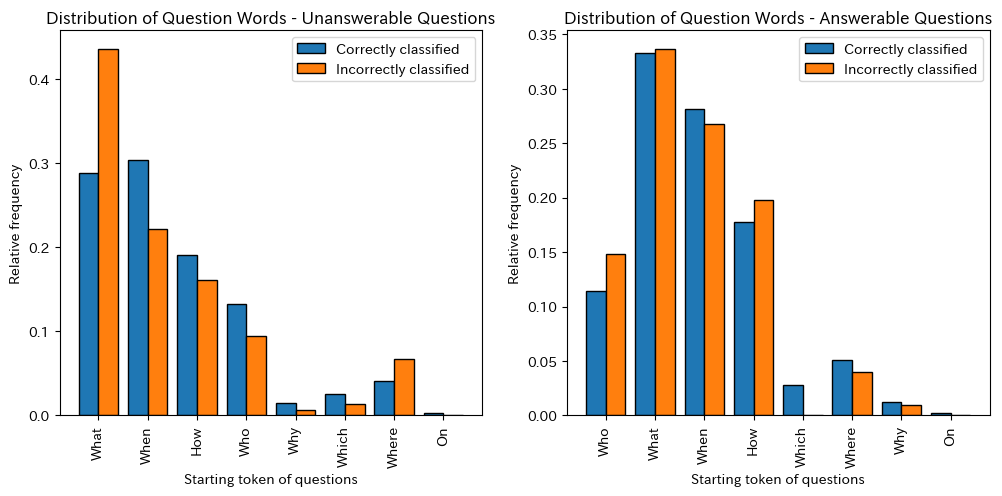

In [ ]:
with open('errors_lab1_english.pickle', 'rb') as file:
    errors_en1 = pickle.load(file)
    
with open('correct_lab1_english.pickle', 'rb') as file:
    correct_en1 = pickle.load(file)

true, prediction = create_arrays(errors_en1, correct_en1)
class_ov_transformer(true, prediction)
errors_en1, correct_en1 = input_length(errors_en1, correct_en1, 'english')
errors_en1, correct_en1 = overlap(errors_en1, correct_en1)
errors_en1, correct_en1 = semantic_features(errors_en1, correct_en1)
errors_en1, correct_en1 = numbers(errors_en1, correct_en1)
unanswerable, answerable = pred_qstword(errors_en1, correct_en1, 'english')
plot_qstwords(unanswerable, answerable)

F1 score: 0.6834264432029795
Accuracy score: 0.6565656565656566
Classification Report: 
              precision    recall  f1-score   support

           0       0.69      0.57      0.62       495
           1       0.63      0.74      0.68       495

    accuracy                           0.66       990
   macro avg       0.66      0.66      0.65       990
weighted avg       0.66      0.66      0.65       990

Confusion Matrix: 
[[283 212]
 [128 367]]
Mean of incorrectly classified answerable questions as unanswerable - Qst = 8.5546875
Mean of incorrectly classified unanswerable questions as answerable - Qst = 8.235849056603774
Mean of correctly classified answerable questions - Qst = 8.08174386920981
Mean of correctly classified unanswerable questions - Qst = 8.180212014134275
Mean of incorrectly classified answerable questions as unanswerable - Ctxt = 127.03125
Mean of incorrectly classified unanswerable questions as answerable - Ctxt = 91.48113207547169
Mean of correctly classified

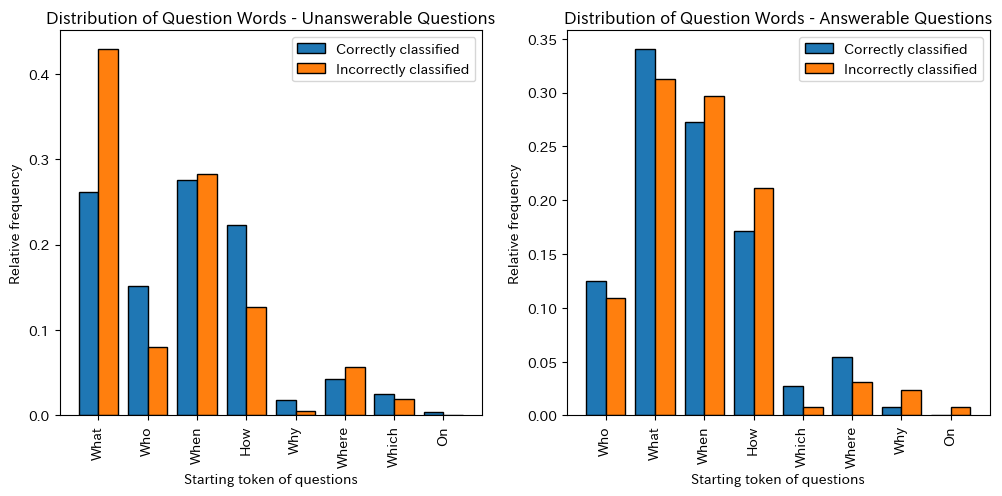

In [ ]:
with open('errors_lab2_english.pickle', 'rb') as file:
    errors_en2 = pickle.load(file)
    
with open('correct_lab2_english.pickle', 'rb') as file:
    correct_en2 = pickle.load(file)

true, prediction = create_arrays(errors_en2, correct_en2)
class_ov_transformer(true, prediction)
errors_en2, correct_en2 = input_length(errors_en2, correct_en2, 'english')
errors_en2, correct_en2 = overlap(errors_en2, correct_en2)
errors_en2, correct_en2 = semantic_features(errors_en2, correct_en2)
unanswerable, answerable = pred_qstword(errors_en2, correct_en2, 'english')
plot_qstwords(unanswerable, answerable)

## Finnish

F1 score: 0.7329902801600915
Accuracy score: 0.7230130486358244
Classification Report: 
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       843
           1       0.71      0.76      0.73       843

    accuracy                           0.72      1686
   macro avg       0.72      0.72      0.72      1686
weighted avg       0.72      0.72      0.72      1686

Confusion Matrix: 
[[578 265]
 [202 641]]
Mean of incorrectly classified answerable questions as unanswerable - Qst = 6.02970297029703
Mean of incorrectly classified unanswerable questions as answerable - Qst = 5.8226415094339625
Mean of correctly classified answerable questions - Qst = 5.784711388455539
Mean of correctly classified unanswerable questions - Qst = 5.852941176470588
Mean of incorrectly classified answerable questions as unanswerable - Ctxt = 71.41089108910892
Mean of incorrectly classified unanswerable questions as answerable - Ctxt = 71.81132075471699
Mean of cor

C:\Users\Hannah\AppData\Local\Temp\ipykernel_31528\315043927.py:319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unanswerable['qst_word'][idx] = f'{unanswerable["qst_word"][idx]}_{translator.translate(unanswerable["qst_word"][idx]).text}'
C:\Users\Hannah\AppData\Local\Temp\ipykernel_31528\315043927.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answerable['qst_word'][idx] = f'{answerable["qst_word"][idx]}_{translator.translate(answerable["qst_word"][idx]).text}'


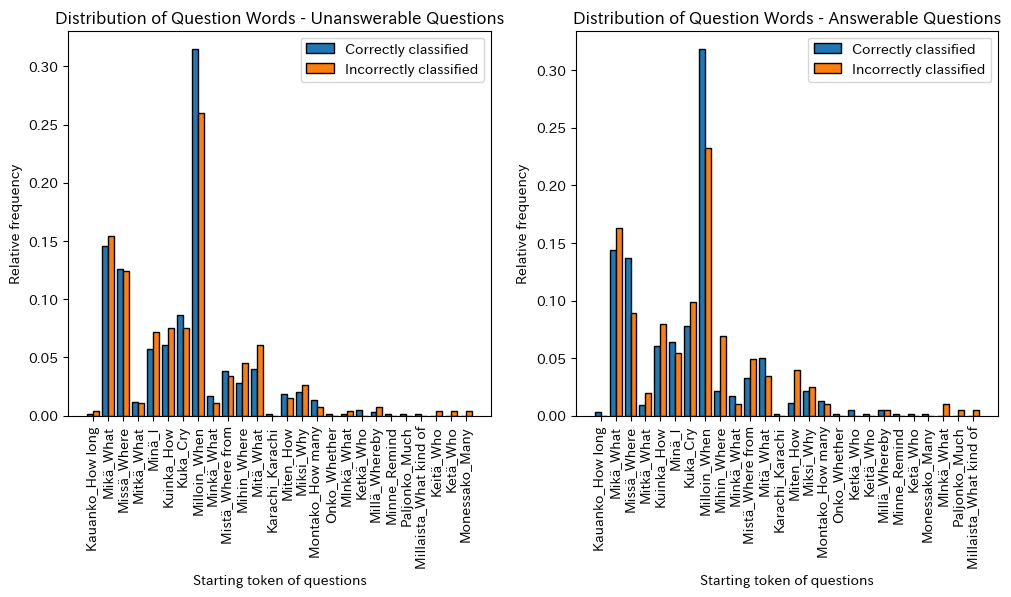

In [ ]:
with open('errors_lab1_finnish.pickle', 'rb') as file:
    errors_fi1 = pickle.load(file)
    
with open('correct_lab1_finnish.pickle', 'rb') as file:
    correct_fi1 = pickle.load(file)

true, prediction = create_arrays(errors_fi1, correct_fi1)
class_ov_transformer(true, prediction)
errors_fi1, correct_fi1 = input_length(errors_fi1, correct_fi1, 'finnish')
errors_fi1, correct_fi1 = overlap(errors_fi1, correct_fi1)
# errors_en1, correct_en1 = semantic_features(errors_en2, correct_fi2)
unanswerable, answerable = pred_qstword(errors_fi1, correct_fi1, 'finnish')
plot_qstwords(unanswerable, answerable)

F1 score: 0.7175080558539205
Accuracy score: 0.6880189798339265
Classification Report: 
              precision    recall  f1-score   support

           0       0.74      0.58      0.65       843
           1       0.66      0.79      0.72       843

    accuracy                           0.69      1686
   macro avg       0.70      0.69      0.68      1686
weighted avg       0.70      0.69      0.68      1686

Confusion Matrix: 
[[492 351]
 [175 668]]
Mean of incorrectly classified answerable questions as unanswerable - Qst = 6.034285714285715
Mean of incorrectly classified unanswerable questions as answerable - Qst = 5.794871794871795
Mean of correctly classified answerable questions - Qst = 5.793413173652695
Mean of correctly classified unanswerable questions - Qst = 5.878048780487805
Mean of incorrectly classified answerable questions as unanswerable - Ctxt = 88.38857142857142
Mean of incorrectly classified unanswerable questions as answerable - Ctxt = 56.794871794871796
Mean of co

C:\Users\Hannah\AppData\Local\Temp\ipykernel_31528\315043927.py:319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unanswerable['qst_word'][idx] = f'{unanswerable["qst_word"][idx]}_{translator.translate(unanswerable["qst_word"][idx]).text}'
C:\Users\Hannah\AppData\Local\Temp\ipykernel_31528\315043927.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answerable['qst_word'][idx] = f'{answerable["qst_word"][idx]}_{translator.translate(answerable["qst_word"][idx]).text}'


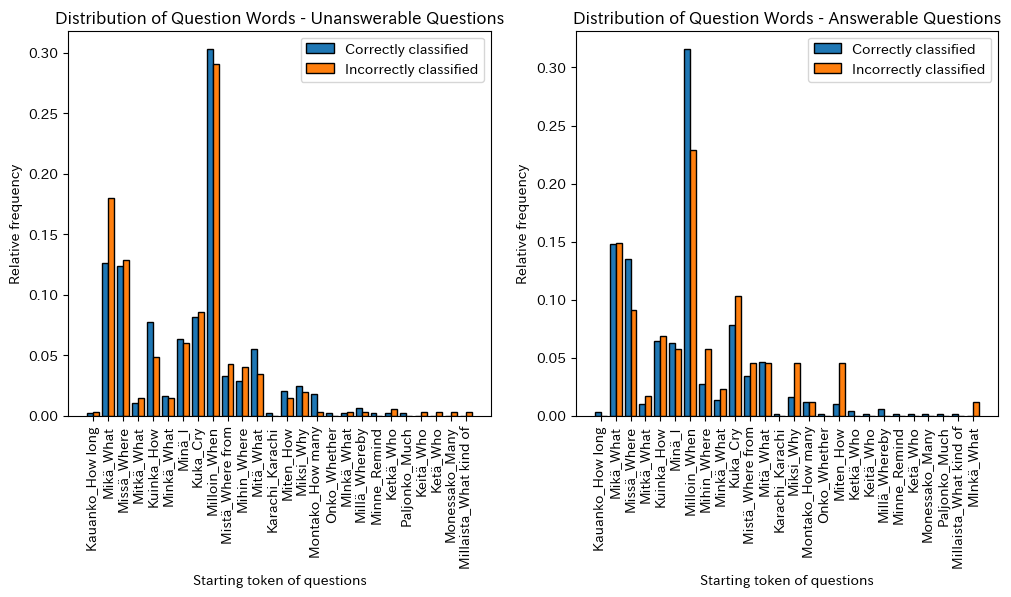

In [ ]:
with open('errors_lab2_finnish.pickle', 'rb') as file:
    errors_fi2 = pickle.load(file)
    
with open('correct_lab2_finnish.pickle', 'rb') as file:
    correct_fi2 = pickle.load(file)

true, prediction = create_arrays(errors_fi2, correct_fi2)
class_ov_transformer(true, prediction)
errors_fi2, correct_fi2 = input_length(errors_fi2, correct_fi2, 'finnish')
errors_fi2, correct_fi2 = overlap(errors_fi2, correct_fi2)
# errors_en1, correct_en1 = semantic_features(errors_en2, correct_fi2)
unanswerable, answerable = pred_qstword(errors_fi2, correct_fi2, 'finnish')
plot_qstwords(unanswerable, answerable)

## Japanese

F1 score: 0.7196172248803827
Accuracy score: 0.7171814671814671
Classification Report: 
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       518
           1       0.71      0.73      0.72       518

    accuracy                           0.72      1036
   macro avg       0.72      0.72      0.72      1036
weighted avg       0.72      0.72      0.72      1036

Confusion Matrix: 
[[367 151]
 [142 376]]
Mean of incorrectly classified answerable questions as unanswerable - Qst = 10.830985915492958
Mean of incorrectly classified unanswerable questions as answerable - Qst = 8.973509933774835
Mean of correctly classified answerable questions - Qst = 9.393617021276595
Mean of correctly classified unanswerable questions - Qst = 10.122615803814714
Mean of incorrectly classified answerable questions as unanswerable - Ctxt = 129.0211267605634
Mean of incorrectly classified unanswerable questions as answerable - Ctxt = 149.58278145695365
Mean of 

C:\Users\Hannah\AppData\Local\Temp\ipykernel_31528\315043927.py:319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unanswerable['qst_word'][idx] = f'{unanswerable["qst_word"][idx]}_{translator.translate(unanswerable["qst_word"][idx]).text}'
C:\Users\Hannah\AppData\Local\Temp\ipykernel_31528\315043927.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answerable['qst_word'][idx] = f'{answerable["qst_word"][idx]}_{translator.translate(answerable["qst_word"][idx]).text}'


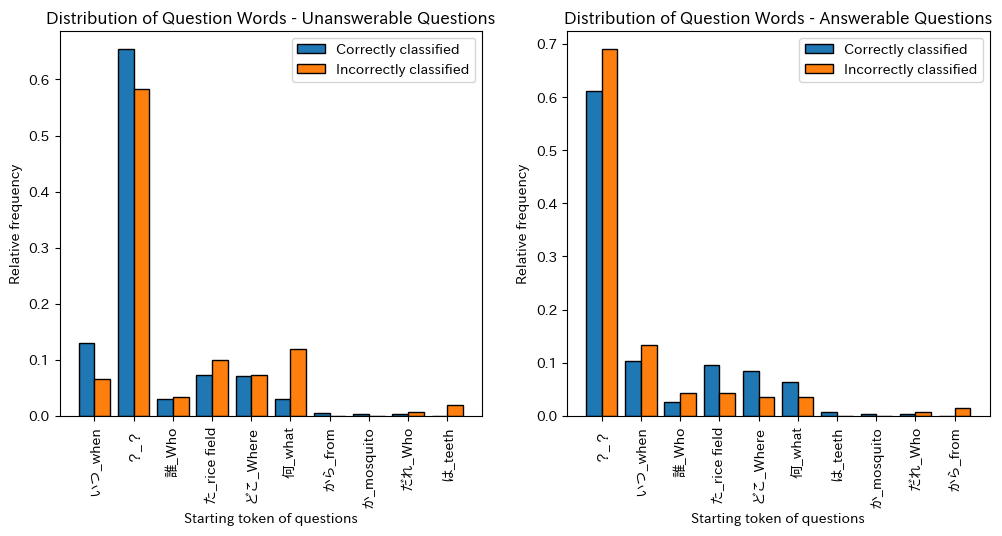

In [ ]:
with open('errors_lab1_japanese.pickle', 'rb') as file:
    errors_ja1 = pickle.load(file)
    
with open('correct_lab1_japanese.pickle', 'rb') as file:
    correct_ja1 = pickle.load(file)

true, prediction = create_arrays(errors_ja1, correct_ja1)
class_ov_transformer(true, prediction)
errors_ja1, correct_ja1 = input_length(errors_ja1, correct_ja1, 'japanese')
errors_ja1, correct_ja1 = overlap(errors_ja1, correct_ja1)
# errors_en1, correct_en1 = semantic_features(errors_en2, correct_fi2)
unanswerable, answerable = pred_qstword(errors_ja1, correct_ja1, 'japanese')
plot_qstwords(unanswerable, answerable)

F1 score: 0.6828391734052112
Accuracy score: 0.6592664092664092
Classification Report: 
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       518
           1       0.64      0.73      0.68       518

    accuracy                           0.66      1036
   macro avg       0.66      0.66      0.66      1036
weighted avg       0.66      0.66      0.66      1036

Confusion Matrix: 
[[303 215]
 [138 380]]
Mean of incorrectly classified answerable questions as unanswerable - Qst = 10.644927536231885
Mean of incorrectly classified unanswerable questions as answerable - Qst = 9.027906976744186
Mean of correctly classified answerable questions - Qst = 9.476315789473684
Mean of correctly classified unanswerable questions - Qst = 10.326732673267326
Mean of incorrectly classified answerable questions as unanswerable - Ctxt = 182.45652173913044
Mean of incorrectly classified unanswerable questions as answerable - Ctxt = 118.24651162790698
Mean of

C:\Users\Hannah\AppData\Local\Temp\ipykernel_31528\315043927.py:319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unanswerable['qst_word'][idx] = f'{unanswerable["qst_word"][idx]}_{translator.translate(unanswerable["qst_word"][idx]).text}'
C:\Users\Hannah\AppData\Local\Temp\ipykernel_31528\315043927.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answerable['qst_word'][idx] = f'{answerable["qst_word"][idx]}_{translator.translate(answerable["qst_word"][idx]).text}'


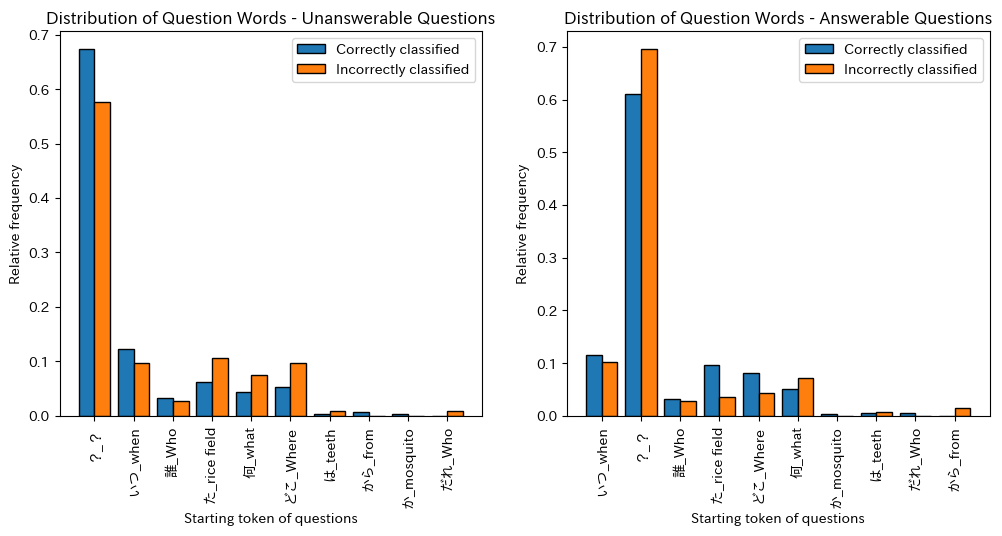

In [ ]:
with open('errors_lab2_japanese.pickle', 'rb') as file:
    errors_ja2 = pickle.load(file)
    
with open('correct_lab2_japanese.pickle', 'rb') as file:
    correct_ja2 = pickle.load(file)

true, prediction = create_arrays(errors_ja2, correct_ja2)
class_ov_transformer(true, prediction)
errors_ja2, correct_ja2 = input_length(errors_ja2, correct_ja2, 'japanese')
errors_ja2, correct_ja2 = overlap(errors_ja2, correct_ja2)
# errors_en1, correct_en1 = semantic_features(errors_en2, correct_fi2)
unanswerable, answerable = pred_qstword(errors_ja2, correct_ja2, 'japanese')
plot_qstwords(unanswerable, answerable)

# Lab 1 Classifier

### English
* Input: 'question_context'
* tokenizer: nltk
* no preprocessing
* tfidf weighting
* F1 score: 0.759152
* Accuracy = 0.747475

In [ ]:
## English
y_train = np.array(train_en['answer_available'])
y_val = np.array(val_en['answer_available'])

train_tok = tokenizeData(train_en, tokenizer = 'nltk', language = 'english')
val_tok = tokenizeData(val_en, tokenizer = 'nltk', language = 'english')

vectorizer = TfidfVectorizer(tokenizer = do_nothing, 
                            preprocessor = do_nothing)

vectorizer = vectorizer.fit(train_tok)
X_train = vectorizer.transform(train_tok)
X_val = vectorizer.transform(val_tok)

log_mod = LogisticRegression(random_state = 42, max_iter = 1000).fit(X_train, y_train)

C:\Users\Hannah\anaconda3\envs\nlp_class\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


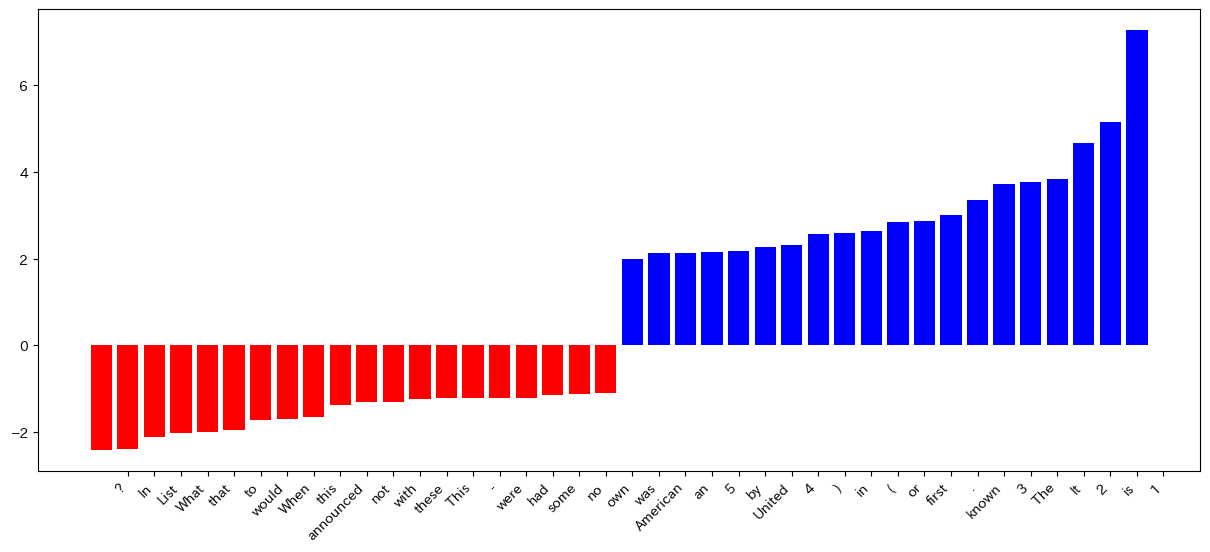

In [ ]:
top_features = 20
coefficients = model.coef_

top_pos_coef = np.argsort(coefficients[0])[-top_features:]
top_neg_coef = np.argsort(coefficients[0])[:top_features]

top_coef = np.hstack([top_neg_coef, top_pos_coef])

features = vectorizer.get_feature_names()

plt.figure(figsize=(15, 6))
colors = ['red' if coef < 0 else 'blue' for coef in coefficients[0][top_coef]]
plt.bar(np.arange(2 * top_features), coefficients[0][top_coef], color = colors)
feature_nam = np.array(features)
plt.xticks(np.arange(1, 1 + 2 * top_features), feature_nam[top_coef], rotation = 45, ha = 'right')
plt.savefig('top_features.png')

In [ ]:
## English
y_train = np.array(train_en['answer_available'])
y_val = np.array(val_en['answer_available'])

train_tok = tokenizeData(train_en, tokenizer = 'nltk', language = 'english')
val_tok = tokenizeData(val_en, tokenizer = 'nltk', language = 'english')

vectorizer = TfidfVectorizer(tokenizer = do_nothing, 
                            preprocessor = do_nothing)

vectorizer = vectorizer.fit(train_tok)
X_train = vectorizer.transform(train_tok)
X_val = vectorizer.transform(val_tok)

log_mod = LogisticRegression(random_state = 42, max_iter = 1000).fit(X_train, y_train)

top_features = 20
coefficients = model.coef_

top_pos_coef = np.argsort(coefficients[0])[-top_features:]
top_neg_coef = np.argsort(coefficients[0])[:top_features]

top_coef = np.hstack([top_neg_coef, top_pos_coef])

features = vectorizer.get_feature_names()

plt.figure(figsize=(15, 6))
colors = ['red' if coef < 0 else 'blue' for coef in coefficients[0][top_coef]]
plt.bar(np.arange(2 * top_features), coefficients[0][top_coef], color = colors)
feature_nam = np.array(features)
plt.xticks(np.arange(1, 1 + 2 * top_features), feature_nam[top_coef], rotation = 45, ha = 'right')
plt.savefig('top_features.png')

##### Numbers

In [ ]:
# Adding numeric tokens to correctly classified unanswerable questions
manip = random.sample(correct_en1[0], 10)

for entry in manip:
    entry.append(entry[6] + entry[8])
    
for entry in manip:
    entry[-1].extend(random.sample(range(1,6), 3))

manip_val = [entry[-1] for entry in manip]

manip_val_mat = vectorizer.transform(manip_val)
pred = model.predict(manip_val_mat)
pred

In [ ]:
# Deleting numeric tokens from correctly classified answerable questions
manip = random.sample(correct_en1[1], 10)

for entry in manip:
    entry.append(entry[6] + entry[8])
    
for entry in manip:
    entry[-1] = [token for token in entry[-1] if token.isnumeric() == False]

manip_val = [entry[-1] for entry in manip]

manip_val_mat = vectorizer.transform(manip_val)
pred = model.predict(manip_val_mat)
pred

##### Length

In [ ]:
# Only keeping instances with inputs longer than 100 tokens of correctly classified answerable questions
long_ctxt = [entry for entry in correct_en1[1] if entry[10] > 100]

# Truncating input to 100 tokens
manip = random.sample(long_ctxt, 10)
for entry in manip:
    entry.append(entry[6] + entry[8])
    entry[-1] = entry[-1][:100]

manip_val = [entry[-1] for entry in manip]
manip_val_mat = vectorizer.transform(manip_val)
pred = model.predict(manip_val_mat)
pred

##### Conjunction words

In [ ]:
# Adding a conjunction word to correctly classified unanswerable instances
manip = random.sample(correct_en1[0], 10)

for entry in manip:
    entry.append(entry[6] + entry[8])
    
for entry in manip:
    entry[-1].append(random.sample(['for', 'and', 'nor', 'but', 'or', 'yet', 'so'], 1)[0])
    
manip_val = [entry[-1] for entry in manip]
manip_val_mat = vectorizer.transform(manip_val)
pred = model.predict(manip_val_mat)
pred

In [ ]:
# Deleting conjunction words from correctly classified answerable instances
manip = random.sample(correct_en1[1], 10)

for entry in manip:
    entry.append(entry[6] + entry[8])
    
for entry in manip:
    entry[-1] = [token for token in entry[-1] if token not in ['for', 'and', 'nor', 'but', 'or', 'yet', 'so']]
    
manip_val = [entry[-1] for entry in manip]
manip_val_mat = vectorizer.transform(manip_val)
pred = model.predict(manip_val_mat)
pred

##### Negation

In [ ]:
# Deleting negation from correctly classified unanswerable instances
manip = random.sample(correct_en1[0], 10)

for entry in manip:
    entry.append(entry[6] + entry[8])
    
for entry in manip:
    entry[-1] = [token for token in entry[-1] if token not in ['not', 'no']]
    
manip_val = [entry[-1] for entry in manip]
manip_val_mat = vectorizer.transform(manip_val)
pred = model.predict(manip_val_mat)
pred

In [ ]:
# Adding a negation to correctly classified answerable instances
manip = random.sample(correct_en1[1], 10)

for entry in manip:
    entry.append(entry[6] + entry[8])
    
for entry in manip:
    entry[-1].append(random.sample(['not', 'no'], 1)[0])
    
manip_val = [entry[-1] for entry in manip]
manip_val_mat = vectorizer.transform(manip_val)
pred = model.predict(manip_val_mat)
pred

##### Incorrectly classified unanswerable 'What'-questions

In [ ]:
errors_unans_what = []


for entry in errors_en1[0]:
    if entry[6][0] == 'What':
        errors_unans_what.append(entry)

len(errors_unans_what)

In [ ]:
for i in range(len(val_en)):
    if val_en['question_text'].iloc[i] == 'What is the surface area of the human cortex?':
        print(val_en['document_plaintext'].iloc[i])
        print(val_en['annotations'].iloc[i]) # incorrectly annotated as answerable

In [ ]:
for i in range(len(val_en)):
    if val_en['question_text'].iloc[i] == 'What is the most common type of edible mushroom?':
        print(val_en['document_plaintext'].iloc[i])
        print(val_en['annotations'].iloc[i]) # incorrect answer, but correctly annotated for classification